In [5]:
import pandas as pd
import numpy as np
import os, sys
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
# from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from keras import backend as bek
# from keras.utils import np_utils
import cv2
import gc

#Data

##Data import

In [6]:
raw_train=pd.read_csv("train.csv")
raw_test=pd.read_csv("test.csv")
submit=pd.read_csv("submission.csv")

In [7]:
raw_train.head()

,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


In [8]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2048 entries, 0 to 2047
Columns: 787 entries, id to 783
dtypes: int64(786), object(1)
memory usage: 12.3+ MB


In [9]:
train=raw_train.copy()
test=raw_test.copy()

##Data 전처리

###x_train

id, digit, letter 열을 다 제거해주고 세로로 길게 되게끔 reshape

In [10]:
x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)

In [11]:
print(x_train[0])

[[[  1]
  [  1]
  [  1]
  [  4]
  [  3]
  [  0]
  [  0]
  [  4]
  [  4]
  [  3]
  [  0]
  [  4]
  [  3]
  [  3]
  [  3]
  [  4]
  [  4]
  [  0]
  [  0]
  [  1]
  [  1]
  [  3]
  [  4]
  [  0]
  [  4]
  [  2]
  [  0]
  [  4]]

 [[  0]
  [  1]
  [  3]
  [  1]
  [  0]
  [  4]
  [  1]
  [  1]
  [  3]
  [  1]
  [  2]
  [  4]
  [  2]
  [  4]
  [  3]
  [  1]
  [  0]
  [  1]
  [  2]
  [  3]
  [  0]
  [  3]
  [  3]
  [  1]
  [  3]
  [  4]
  [  1]
  [  3]]

 [[  2]
  [  0]
  [  4]
  [  4]
  [  2]
  [  3]
  [  2]
  [  3]
  [  0]
  [  0]
  [  4]
  [  0]
  [  2]
  [ 16]
  [ 73]
  [ 51]
  [ 21]
  [  1]
  [  2]
  [  1]
  [  4]
  [  3]
  [  3]
  [  2]
  [  1]
  [  3]
  [  3]
  [  3]]

 [[  0]
  [  2]
  [  4]
  [  1]
  [  0]
  [  0]
  [  0]
  [  0]
  [  1]
  [  0]
  [  0]
  [  3]
  [108]
  [176]
  [249]
  [190]
  [128]
  [  3]
  [  0]
  [  3]
  [  1]
  [  1]
  [  4]
  [  0]
  [  4]
  [  3]
  [  3]
  [  3]]

 [[  3]
  [  0]
  [  0]
  [  4]
  [  2]
  [  3]
  [  1]
  [  4]
  [  4]
  [  3]
  [  3]
  [  4]


20 이하인 값들을 다 떨궈버리고 255로 나눕니다

In [12]:
x_train = np.where((x_train<=20)&(x_train!=0) ,0.,x_train)
x_train = x_train/255
x_train = x_train.astype('float32')

###y_train

In [13]:
y = train['digit']
print(len(y))
print(y.unique())
y_train = np.zeros((len(y), len(y.unique())))  # 총 행의수 , 10(0~9)
y_train[2]

2048
[5 0 4 9 6 8 1 3 2 7]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

i가 번째(순서), digit이 그 번째 사진의 답

답인 행에 1

In [14]:
for i, digit in enumerate(y):
    y_train[i, digit] = 1

y_train[:5,:]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [15]:
train_224=np.zeros([2048,300,300,3],dtype=np.float32)
print(train_224[:1,:])

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]]


##Image resize

300x300의 grayscale

In [17]:
for i, s in enumerate(x_train):
    converted = cv2.cvtColor(s, cv2.COLOR_GRAY2RGB)
    resized = cv2.resize(converted,(300,300),interpolation = cv2.INTER_CUBIC)
    del converted
    train_224[i] = resized
    del resized
    bek.clear_session()
    gc.collect()

##Data Augmentation

In [18]:
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

In [19]:
datagen = ImageDataGenerator(
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.15,
        rotation_range = 10,
        validation_split=0.2)

#Model

In [20]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

EfficientNet: network의 depth, width, 그리고 resolution사이의 관계에 대한 균형을 맞춰야 더 나은 성능을 보인다

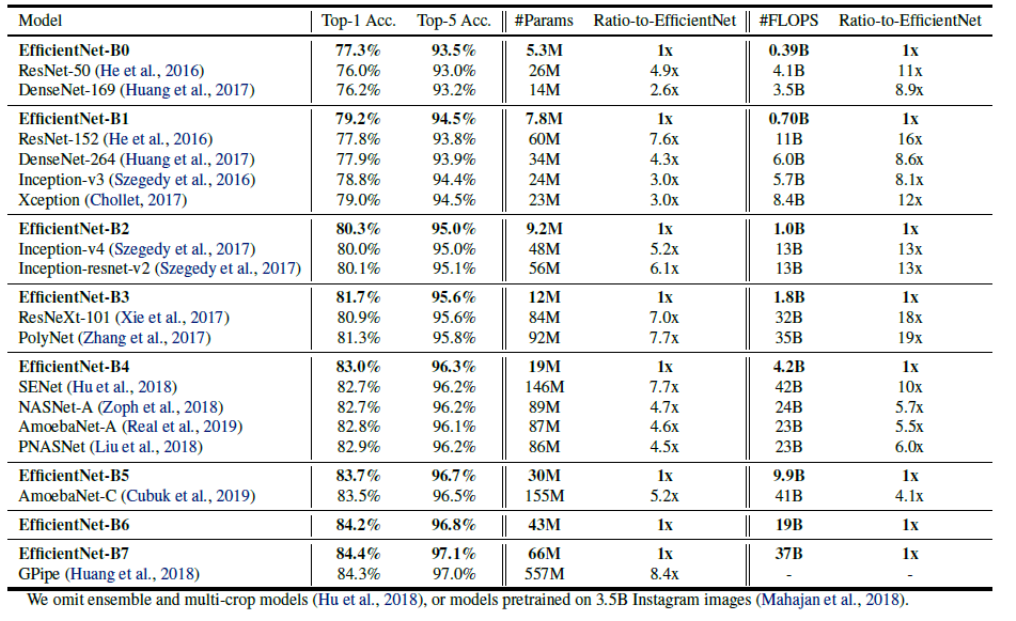

이 코드는 EfficientNet-B3 사용

In [21]:
def create_model() :
    effnet = tf.keras.applications.EfficientNetB3(
        include_top=True,
        weights=None,
        input_shape=(300,300,3),
        classes=10,
        classifier_activation="softmax",
    )
    
    model = Sequential()
    model.add(effnet)

    model.compile(loss="categorical_crossentropy",
                optimizer=RMSprop(lr=initial_learningrate),
                metrics=['accuracy'])
    return model

In [22]:
initial_learningrate=2e-3  
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold

##RepeatedKFold
교차검증의 한 방법:
train과 test를 적절히 잘 나누기 위해서 다양한 매개변수가 필요한데 적절한 매개변수를 찾는 방법 중 하나

1.   데이터를 k개의 Group으로 나눕니다. (Ramdomly)
2.   한 그룹을 학습에 사용합니다.
3.   다른 그룹을 사용하여 Test 및 성능을 평가합니다.
4.   2,3번 과정을 k번 반복합니다.
5.   모든 결과의 평균을 측정합니다.

https://davinci-ai.tistory.com/18

In [23]:
kfold = RepeatedKFold(n_splits=5, n_repeats=10, random_state=40)
cvscores = []
Fold = 1
results = np.zeros((20480,10) )
def lr_decay(epoch):#lrv
    return initial_learningrate * 0.99 ** epoch

#Test

train과 같게끔 test에도 실행

20480이 너무 큰건지 RAM이 부족해서 안 돌아감

In [ ]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = np.where((x_test<=20)&(x_test!=0) ,0.,x_test)
# x_test = np.where(x_test>=145,255.,x_test)
x_test = x_test/255
x_test = x_test.astype('float32')

test_224=np.zeros([20480,300,300,3],dtype=np.float32)

In [ ]:
for i, s in enumerate(x_test):
    converted = cv2.cvtColor(s, cv2.COLOR_GRAY2RGB)
    resized = cv2.resize(converted,(300,300),interpolation = cv2.INTER_CUBIC)
    del converted
    test_224[i] = resized
    del resized

In [ ]:
bek.clear_session()
gc.collect()
results = np.zeros((20480,10),dtype=np.float32)

#Train

In [ ]:
for train, val in kfold.split(train_224): 
    # if Fold<25:
    #   Fold+=1
    #   continue
    
    initial_learningrate=2e-3  
    es = EarlyStopping(monitor='val_loss', verbose=1, patience=50)      
    filepath_val_acc="/content/MyDrive/My Drive/Colab Notebooks/models/effi_model_aug"+str(Fold)+".ckpt"
    checkpoint_val_acc = ModelCheckpoint(filepath_val_acc, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max',save_weights_only=True)


    gc.collect()
    bek.clear_session()
    print ('Fold: ',Fold)
    
    X_train = train_224[train]
    X_val = train_224[val]
    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')
    Y_train = y_train[train]
    Y_val = y_train[val]

    model = create_model()


    training_generator = datagen.flow(X_train, Y_train, batch_size=32,seed=7,shuffle=True)
    validation_generator = valgen.flow(X_val, Y_val, batch_size=32,seed=7,shuffle=True)
    model.fit(training_generator,epochs=150,callbacks=[LearningRateScheduler(lr_decay),es,checkpoint_val_acc],
               shuffle=True,
               validation_data=validation_generator,
               steps_per_epoch =len(X_train)//32
               )
    del X_train
    del X_val
    del Y_train
    del Y_val

    gc.collect()
    bek.clear_session()
    model.load_weights(filepath_val_acc)
    results = results + model.predict(test_224)
    
    Fold = Fold +1
    
submission = pd.read_csv('/content/MyDrive/My Drive/Colab Notebooks/data/submission.csv')
submission['digit'] = np.argmax(results, axis=1)
# model.predict(x_test)
submission.head()
submission.to_csv('/content/MyDrive/My Drive/Colab Notebooks/loadtest2.csv', index=False)
# np.savetxt('/content/MyDrive/My Drive/Colab Notebooks/data/results.csv',results ,delimiter=',')
 
# submission = pd.read_csv('/content/MyDrive/My Drive/Colab Notebooks/data/submission.csv')
# submission['digit'] = np.argmax(results, axis=1)
# submission.head()
# submission.to_csv('/content/MyDrive/My Drive/Colab Notebooks/kfold_effi_5.csv', index=False) 

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tensorflow.keras.optimizers import RMSprop
# from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import cv2

import gc
from keras import backend as bek

test = pd.read_csv('/content/MyDrive/My Drive/Colab Notebooks/data/test.csv')

x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = np.where((x_test<=20)&(x_test!=0) ,0.,x_test)
# x_test = np.where(x_test>=145,255.,x_test)
x_test = x_test/255
x_test = x_test.astype('float32')

test_224=np.zeros([20480,300,300,3],dtype=np.float32)


for i, s in enumerate(x_test):
    converted = cv2.cvtColor(s, cv2.COLOR_GRAY2RGB)
    resized = cv2.resize(converted,(300,300),interpolation = cv2.INTER_CUBIC)
    del converted
    test_224[i] = resized
    del resized

bek.clear_session()
gc.collect()

effnet = tf.keras.applications.EfficientNetB3(
    include_top=True,
    weights=None,
    input_shape=(300,300,3),
    classes=10,
    classifier_activation="softmax",
)



loaded_model = Sequential()
loaded_model.add(effnet)


loaded_model.compile(loss="categorical_crossentropy",
            optimizer=RMSprop(lr=2e-3),
            metrics=['accuracy'])

del x_test
del test
results = np.zeros( (20480,10),dtype=np.float16)

for j in range(50):
  filepath_val_acc="/content/MyDrive/My Drive/Colab Notebooks/models/effi_model_aug"+str(j+1)+".ckpt"
  loaded_model.load_weights(filepath_val_acc)
  results = results + loaded_model.predict(test_224)
  
  del filepath_val_acc
  bek.clear_session()
  gc.collect()
  
np.savetxt('/content/MyDrive/My Drive/Colab Notebooks/data/results.csv',results ,delimiter=',')  ## 유사도 판정표

# Predict 결과를 앙상블하여 최종적인 예측값 결정

submission = pd.read_csv('/content/MyDrive/My Drive/Colab Notebooks/data/submission.csv')
submission['digit'] = np.argmax(results, axis=1)
# model.predict(x_test)
submission.head()
submission.to_csv('/content/MyDrive/My Drive/Colab Notebooks/loadtest2.csv', index=False)